In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Spectral Clustering

Spectral Clustering is an alternative clustering algorithm to k-means and Hierarchical Clustering. 
Spectral Clustering can capture complex cluster structures and, unlike Hierarchical Clustering, can handle medium/large sized datasets. 
Its drawback: Spectral Clustering has human-specified parameter $\sigma$. 
It is, however, possible to deduce a good parameter $\sigma$ by trial and error.

Spectral clustering has a long history. 
As a machine learning method, it was popularized by Ng, Jordan, and Weiss:

https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf

**Contents**

- [The Laplacian matrix](#1.-The-Laplacian-matrix)
- [Spectral clustering step-by-step example](#2.-Spectral-clustering-step-by-step-example)
- [Spectral clustering implementation](#3.-Spectral-clustering-implementation)
- [Examples](#4.-Examples)

## 1. The Laplacian matrix

Spectral Clustering uses the eigenvectors of the **Laplacian matrix**. 
The Laplacian matrix is constructed as follows.

First, we form the **affinity matrix**. 
The affinity matrix $A$ is an $m\times m$ (where $m$ is the size of the dataset) whose $(i,j)$ entry is

$$
A_{ij} = \exp \left(\frac{-\|x_i-x_j\|^2}{2\sigma^2}\right).
$$

The parameter $\sigma$ controls how rapidly the affinity $A_{ij}$ falls off with the distance between the points $x_i$ and $x_j$.

Second, we form the **degree matrix**. The degree matrix $D$ is an $m\times m$ diagonal matrix whose $(i,i)$ entry is the sum of A's $i$th row.

$$
D_{ii} = \sum_{j=1}^m A_{ij}.
$$

The **Laplaciam matrix** is the symmetric matrix

$$
L = D^{-1/2} A D^{-1/2},
$$

where $D^{-1/2}$ denotes the matrix inverse of $D^{1/2}$, and where $D^{1/2}$ is a diagonal matrix whose $(i,i)$ entry is the square root of the $(i,i)$ entry of $D$.

In [2]:
def Laplacian_matrix(X,sigma):
    
    # dataset size and number of features
    m,n=X.shape
    
    # distance matrix
    distances = np.sum(X**2,axis=1)[:,None]+np.sum(X**2,axis=1)[None,:]-2*X.dot(X.T)
    
    # Affinity matrix
    A = np.exp(-distances/(2*sigma**2))
    np.fill_diagonal(A, 0)
    
    # degree matrix
    D = np.sum(A,axis=1)
    D = np.sqrt(D)
   
    # return Laplacian matrix
    return (A/D[None,:])/D[:,None]

## 2. Spectral clustering step-by-step example

Let us consider the following dataset with two clusters.

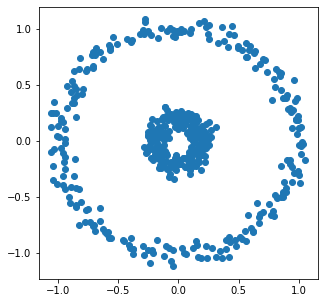

In [26]:
from sklearn.datasets import make_circles
X,y = make_circles(n_samples=500,noise=0.05, factor=0.2)


plt.figure(figsize=(5,5))
plt.plot(X[:,0],X[:,1],'o')

**step 1**. Form the Laplacian matrix

In [75]:
sigma = 0.25
L = Laplacian_matrix(X,sigma)

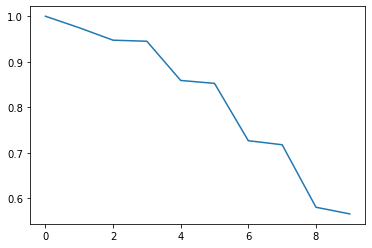

In [76]:
e,_ = np.linalg.eig(L)
e = np.sort(e)[::-1]
plt.plot(e[0:10])

**step 2**. Find the eigenvectors $v_1,v_2,\ldots,v_k$ of the Laplacian matrix corresponding to the $k$ largest eigenvalues. 
Form the matrix

$$
V = 
\begin{bmatrix}
    v_1 & v_2 & \cdots & v_k
\end{bmatrix}
$$

by staking the eigenvectors in columns.

In [77]:
m = L.shape[0]
m

500

In [78]:
k = 2

In [79]:
from scipy.linalg import eigh
_,V = eigh(L,eigvals=(m-k,m-1)) 

**step 3**. Normalize each of V's rows to have unit norm.

In [80]:
V = V/np.linalg.norm(V,axis=1,keepdims=True)

Now the magic. 
Steps 1--3 maps the original points to points in the unit circle. 
The two original clusters (the outer circle and the blob at the origin) are transformed into two tight clusters that lie at 90 degrees to each other relative to the origin.

Text(0.5, 1.0, 'transformed dataset')

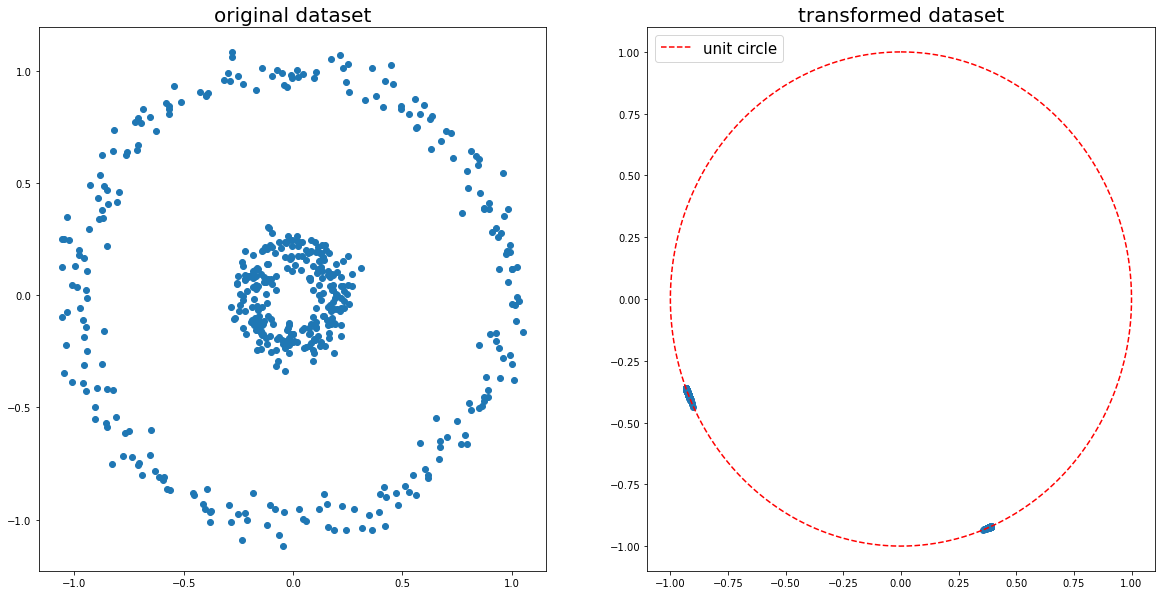

In [81]:
plt.figure(figsize=(20,10))

# original dataset
plt.subplot(1,2,1)
plt.plot(X[:,0],X[:,1],'o')
plt.title('original dataset',fontsize=20)

# transformed datasert
theta = np.linspace(0,2*np.pi,1000) 
x_unit_circle = np.sin(theta)
y_unit_circle = np.cos(theta)
plt.subplot(1,2,2)
plt.plot(V[:,0],V[:,1],'o')
plt.plot(x_unit_circle,y_unit_circle,'r--',label='unit circle')
plt.legend(fontsize=15,loc='upper left')
plt.title('transformed dataset',fontsize=20)

The transformed clusters can be easily found by the k-means algorithm

In [82]:
def kmeans(X,k,max_iterations=1000, return_inertia=False):
    
    # initialize iteration counter
    it = 0
    repeat = True
    
    # number of datapoints
    m = X.shape[0] 
    
    # initialization
    means = X[np.random.choice(m,k)] 
    distances = np.sum(X**2,axis=1)[:,None]+np.sum(means**2,axis=1)[None,:]-2*X.dot(means.T)
    clusters = np.argmin(distances, axis=1)
 
    
    while repeat and it<max_iterations:
        
        # update means; # if a cluster has no data points associated with it, replace it with a random data point
        means = np.array([np.mean(X[clusters==i], axis=0) 
                          if np.sum(clusters==i)!=0
                          else  X[np.random.randint(m)]
                          for i in range(k)])
        
        # update clusters
        distances = np.sum(X**2,axis=1)[:,None]+np.sum(means**2,axis=1)[None,:]-2*X.dot(means.T)
        new_clusters = np.argmin(distances, axis=1)
        
        # check if the new clusters are equal to the previous clusters
        if np.sum(clusters!=new_clusters)==0: 
            repeat = False
        clusters = new_clusters
                
        it += 1 # increment iteration counter by 1
    
    
    results = {'clusters' : clusters, 'means' : means}
    # compute inertia
    if return_inertia:
        results['inertia'] = np.sum([np.sum((X[clusters==i]-means[i])**2) for i in range(k)])/m
    
    return results

In [83]:
results = kmeans(V,k)
clusters = results['clusters']

Text(0.5, 1.0, 'transformed dataset')

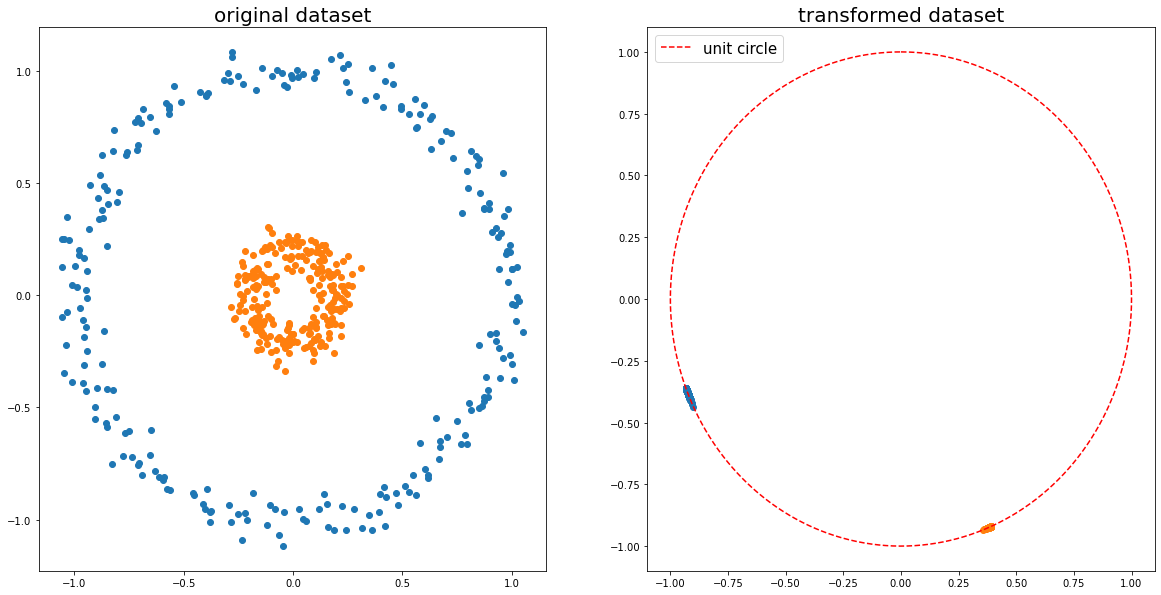

In [84]:
plt.figure(figsize=(20,10))

# original dataset
plt.subplot(1,2,1)
for i in range(k):
    plt.plot(X[clusters==i,0],X[clusters==i,1],'o')
plt.title('original dataset',fontsize=20)

# transformed datasert
theta = np.linspace(0,2*np.pi,1000) 
x_unit_circle = np.sin(theta)
y_unit_circle = np.cos(theta)
plt.subplot(1,2,2) 
for i in range(k):
    plt.plot(V[clusters==i,0],V[clusters==i,1],'o')
plt.plot(x_unit_circle,y_unit_circle,'r--',label='unit circle')
plt.legend(fontsize=15,loc='upper left')
plt.title('transformed dataset',fontsize=20)

## 3. Spectral clustering implementation

In [13]:
def spectral_clustering(X,k,sigma):
    
    # form Laplacian matrix
    L = Laplacian_matrix(X,sigma)
    m = L.shape[0]
    
    # find k largest eigenvectors
    from scipy.linalg import eigh
    _,V = eigh(L,eigvals=(m-k,m-1)) 
    
    # normalize rows of V
    V = V/np.linalg.norm(V,axis=1,keepdims=True)
    
    # apply k-means to rows of V
    results = kmeans(V,k)
    
    return results['clusters']

## 4. Examples

**Example 1**

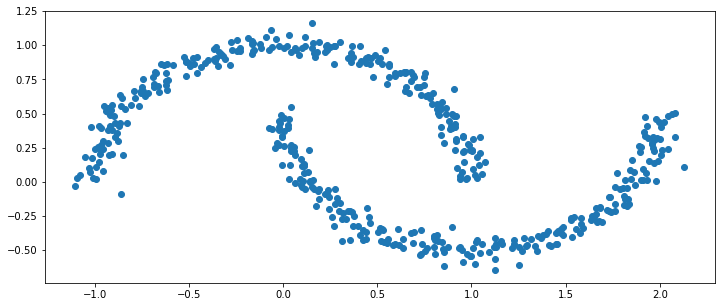

In [14]:
from sklearn.datasets import make_moons
X,y = make_moons(n_samples= 500,noise=0.05)

plt.figure(figsize=(12,5))
plt.plot(X[:,0],X[:,1],'o')

In [15]:
k = 2
sigma = 0.15
clusters = spectral_clustering(X,k,sigma)

Text(0.5, 1.0, 'original dataset')

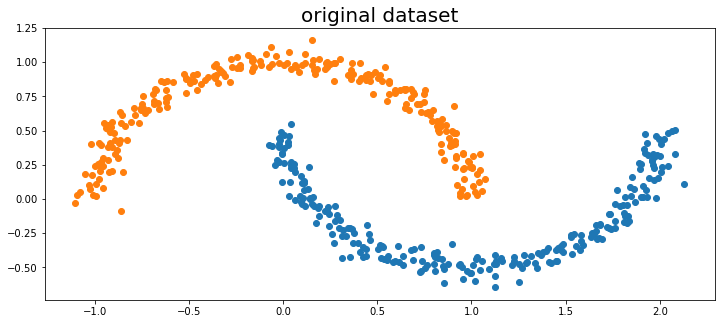

In [16]:
# clusters
plt.figure(figsize=(12,5))
for i in range(k):
    plt.plot(X[clusters==i,0],X[clusters==i,1],'o')
plt.title('original dataset',fontsize=20)

**Example 2**

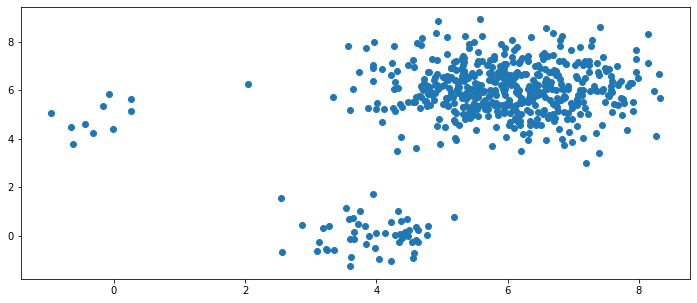

In [17]:
X = np.zeros((560,2)) 
X[0:500] = np.random.randn(500,2) + [6,6] # blob 1 (big)
X[500:550] = 0.7*np.random.randn(50,2) + [4,0] # blob 2 (medium)
X[550:560] = 0.5*np.random.randn(10,2) + [0,5] # blob 3 (small)

plt.figure(figsize=(12,5))
plt.plot(X[:,0],X[:,1],'o')

Text(0.5, 1.0, 'original dataset')

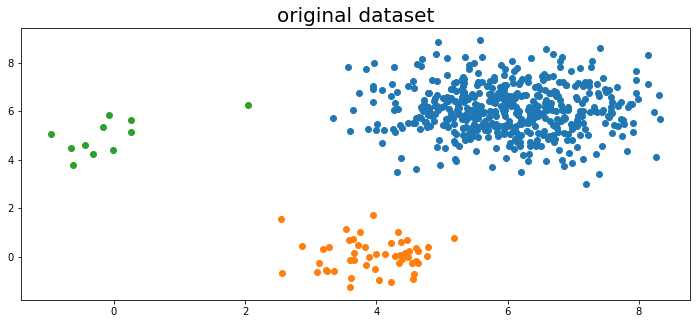

In [18]:
k = 3
sigma = 1
clusters = spectral_clustering(X,k,sigma)

# clusters
plt.figure(figsize=(12,5))
for i in range(k):
    plt.plot(X[clusters==i,0],X[clusters==i,1],'o')
plt.title('original dataset',fontsize=20)

**Example 3**

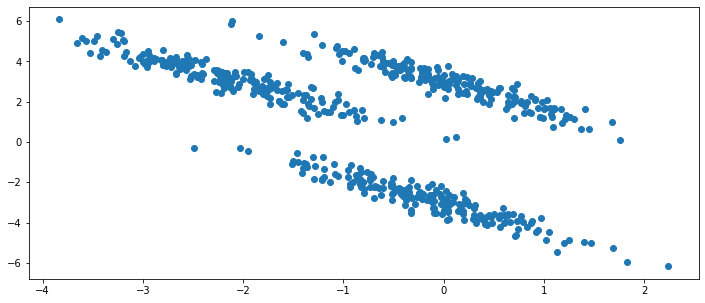

In [19]:
X = np.zeros([600,2])
transformation = np.array([[0.60834549, -0.63667341], [-0.40887718, 0.85253229]])

X[0:200] = np.random.randn(200,2) + [-2,2]
X[200:400] = np.random.randn(200,2) + [5,7]
X[400:600] = np.random.randn(200,2) + [-5,-7]

X = X.dot(transformation)
plt.figure(figsize=(12,5))
plt.plot(X[:,0],X[:,1],'o')

Text(0.5, 1.0, 'original dataset')

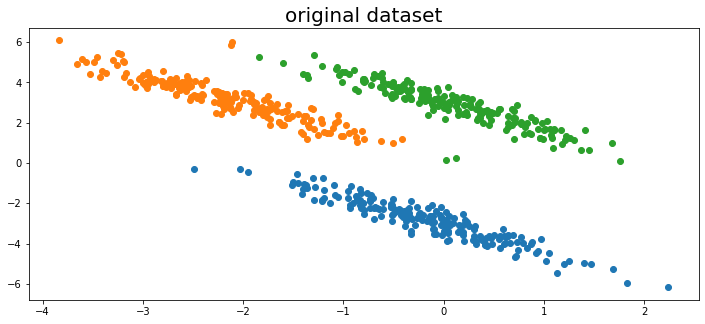

In [20]:
k = 3
sigma = 0.5
clusters = spectral_clustering(X,k,sigma)

# clusters
plt.figure(figsize=(12,5))
for i in range(k):
    plt.plot(X[clusters==i,0],X[clusters==i,1],'o')
plt.title('original dataset',fontsize=20)